## Mean shift

Implementing mean shift evolution

In [7]:
import jax
import jax.random as random
import jax.numpy as jnp

import equinox as eqx
import equinox.nn as nn

import numpy as np
import matplotlib.pyplot as plt

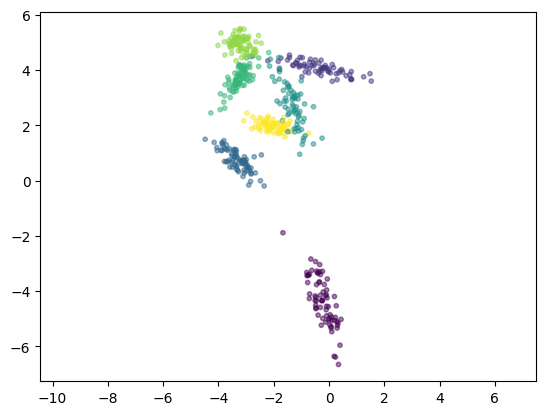

In [35]:
import jax.numpy as jnp
import jax.random as random

def create_data(key, n=1000, d=2, k=5):
    """MoG with fast eigenvalue decay, different random rotations."""
    keys = random.split(key, k+3)
    
    # Different random rotation for each cluster
    Q = jnp.array([jnp.linalg.qr(random.normal(keys[i], (d, d)))[0] 
                   for i in range(k)])
    
    # Random centers (spread them out MORE)
    centers = random.normal(keys[k], (k, d)) * 3
    
    # Assign & generate with 1/n^2 decay
    labels = random.randint(keys[k+1], (n,), 0, k)
    z = random.normal(keys[k+2], (n, d))
    decay = 1 / jnp.arange(1, d+1)**2
    
    data = jnp.array([centers[labels[i]] + Q[labels[i]] @ (z[i] * jnp.sqrt(decay) * 3) 
                      for i in range(n)])
    
    return data, labels

# Use
key = random.PRNGKey(0)
data, labels = create_data(key, n=500, d=100, k=7)

import matplotlib.pyplot as plt
plt.scatter(data[:, 0], data[:, 1], c=labels, s=10, alpha=0.5)
plt.axis('equal')
plt.show()

## 1. Mean Shift

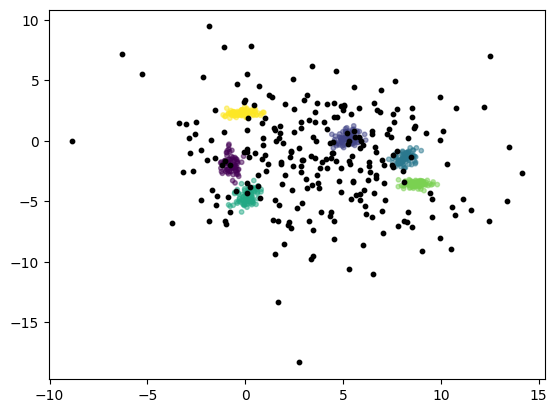

In [36]:
n_data = 500
n_code = 250
n_cluster = 6
d = 64

key = jax.random.PRNGKey(42)


data, labels = create_data(key, n=n_data, d=d, k=n_cluster)

mu_data = jnp.mean(data, axis=0)

codes = mu_data + 4 * jax.random.normal(key, shape=(n_code, d)) 

plt.scatter(data[:, 0], data[:, 1], c=labels, s=10, alpha=0.5)
plt.scatter(codes[:, 0], codes[:, 1], s=10, alpha=1.0, c="black")

In [37]:
def norm(x): return jnp.sqrt(jnp.sum((x)**2))
def sqdist(x1, x2): return jnp.sum((x1 - x2)**2)
def cossim(x1, x2): return jnp.sum(x1 * x2) / (norm(x1) * norm(x2))

def dot_kernel(X1, X2):
    return X2 @ X1.T

def sq_kernel(X1, X2):
    """||a - b||^2 = ||a||^2 - 2 * a @ b^T + ||b||^2"""
    a_sq = jnp.sum(X1 * X1, axis=1, keepdims=True).T
    b_sq = jnp.sum(X2 * X2, axis=1, keepdims=True)
    ab = X2 @ X1.T
    return - (a_sq - 2 * ab + b_sq)

@jax.jit
def code_energy(codes, data, kernel=sq_kernel, beta=1):
    sims = kernel(codes, data)
    return -jax.nn.logsumexp(sims / beta, axis=0)

def code_grad(codes, data, kernel=sq_kernel, beta=1):
    sims = kernel(codes, data)
    smx = jax.nn.softmax(sims / beta, axis=0)
    return codes - smx.T @ data, -jax.nn.logsumexp(sims / beta, axis=0)

@jax.jit
def code_shift(codes, data, kernel=sq_kernel, beta=1):
    sims = kernel(codes, data)
    smx = jax.nn.softmax(sims / beta, axis=0)
    return smx.T @ data, -jax.nn.logsumexp(sims, axis=0)


(array([ 6., 16., 36., 60., 50., 48., 21.,  7.,  4.,  2.]),
 array([159.10525513, 179.46864319, 199.83203125, 220.19541931,
        240.55880737, 260.92218018, 281.2855835 , 301.64898682,
        322.01235962, 342.37573242, 362.73913574]),
 <BarContainer object of 10 artists>)

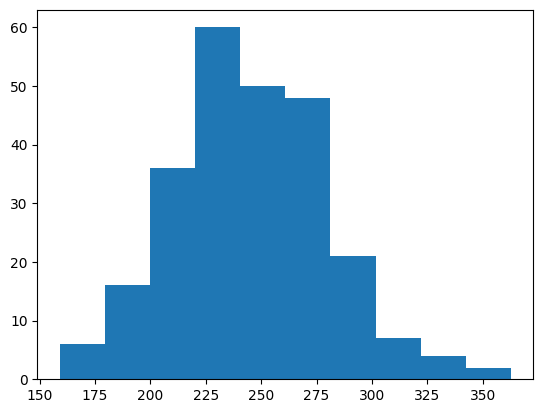

In [40]:
plt.hist(code_energy(codes, data, beta=5))

In [41]:
import optax
from functools import partial

key = jax.random.PRNGKey(42)

lr = 5e-2
steps = 200
optim = optax.sgd(learning_rate=lr)
beta = 5
sigma = 0.1

opt_state = optim.init(codes)
energy_vals = []
codes_history = [codes.copy()]  # Add this line

@partial(jax.jit, static_argnames=["kernel"])
def code_step(codes, opt_state, kernel=sq_kernel):
    grad, energy = code_grad(codes, data, kernel=kernel, beta=10.0)
    updates, opt_state = optim.update(grad, opt_state, codes)
    return updates, opt_state, jnp.mean(energy)

for step in range(steps):
    updates, opt_state, energy = code_step(codes, opt_state)
    codes = optax.apply_updates(codes, updates)

    key, key_rand = jax.random.split(key)
    eps = jax.random.normal(key_rand, shape=codes.shape)

    codes = codes + sigma * eps

    codes_history.append(codes.copy())  # Add this line


    energy_vals.append(energy)

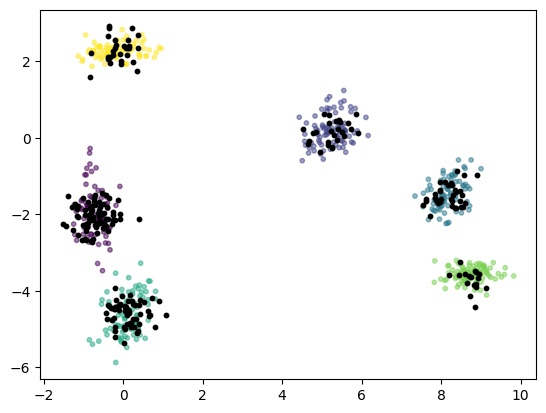

In [42]:

plt.scatter(data[:, 0], data[:, 1], c=labels, s=10, alpha=0.5)
plt.scatter(codes[:, 0], codes[:, 1], s=10, alpha=1.0, c="black")

(array([ 8., 15., 25., 45., 54., 40., 28., 22.,  8.,  5.]),
 array([-1.95423651, -1.83599079, -1.71774507, -1.59949934, -1.48125362,
        -1.3630079 , -1.24476218, -1.12651646, -1.00827074, -0.89002502,
        -0.7717793 ]),
 <BarContainer object of 10 artists>)

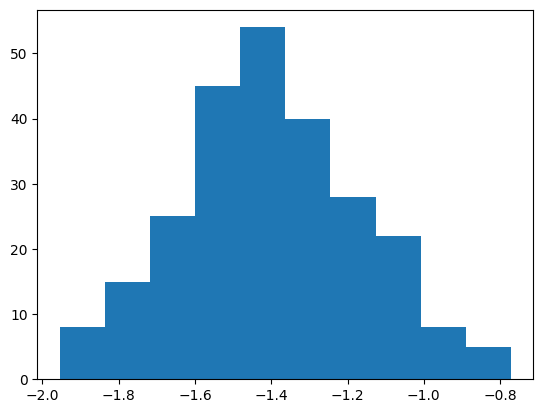

In [43]:
plt.hist(code_energy(codes, data, beta=5))

Array(-2.7069535, dtype=float32)

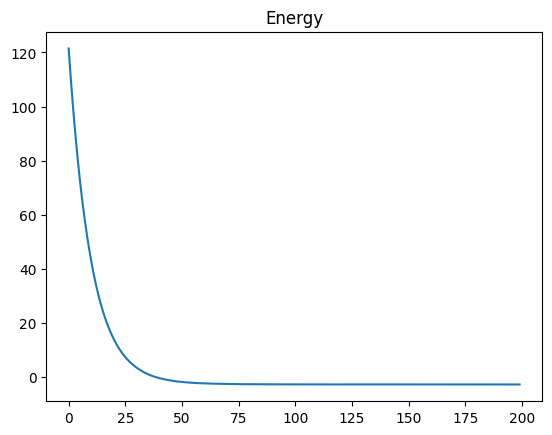

In [34]:
plt.plot(energy_vals)
plt.title("Energy")
energy_vals[-1]

In [22]:
len(codes_history)

201

In [ ]:


# Create GIF
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()
skip = 1  # Show every 100th frame

def animate(i):
    ax.clear()
    ax.scatter(data[:, 0], data[:, 1], c=labels, s=10, alpha=0.5)
    ax.scatter(codes_history[i*skip][:, 0], codes_history[i*skip][:, 1], 
               s=50, c='red', marker='x')
    ax.set_title(f'Step {i*skip}')

anim = FuncAnimation(fig, animate, frames=len(codes_history)//skip, interval=50)
anim.save('mean_shift.gif', writer=PillowWriter(fps=10), dpi=300)